In [1]:
# Burger gleichung mit viskosem Term
import sys
sys.path.append('/home/inu2sh/Python/PINN/src')
import torch
import os
import numpy as np
import pytorch_lightning as pl
from timeit import default_timer as timer

from torchphysics.problem import Variable
from torchphysics.setting import Setting
from torchphysics.problem.domain import Rectangle,Interval,Circle
from torchphysics.problem.domain.domain_operations import Cut
from torchphysics.problem.condition import (DirichletCondition,
                                              DiffEqCondition,
                                              DataCondition)
from torchphysics.models.fcn import SimpleFCN
from torchphysics import PINNModule
from torchphysics.utils import laplacian, jac
from torchphysics.utils.fdm import FDM, create_validation_data
from torchphysics.utils.plot import Plotter
from torchphysics.utils.evaluation import (get_min_max_inside,
                                             get_min_max_boundary)
from torchphysics.setting import Setting

os.environ["CUDA_VISIBLE_DEVICES"] = "0" # select GPUs to use 0,1,2 

#pl.seed_everything(43) # set a global seed
torch.cuda.is_available()

True

In [2]:
w, h = 5, 1
t0, tend = 0, 20
Re = 50

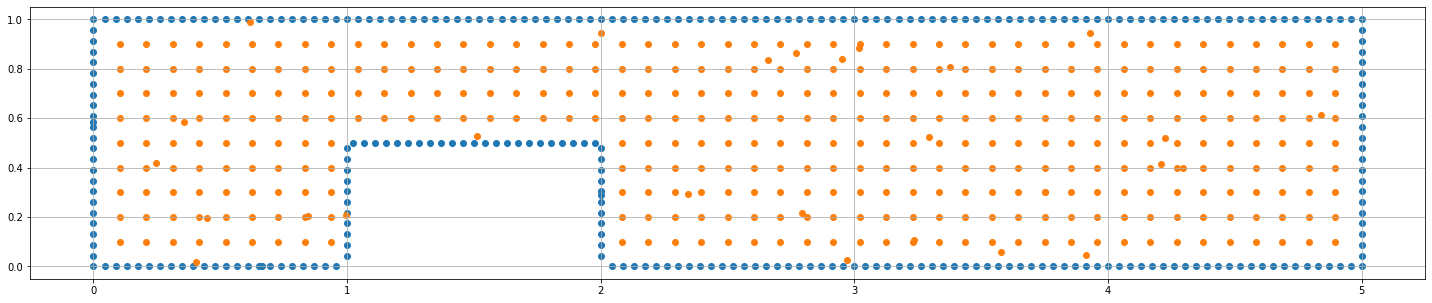

In [3]:
# R ist Domain-Name
R = Rectangle(corner_dl=[0, 0], corner_dr=[w, 0], corner_tl=[0, h])
O = Rectangle(corner_dl=[1, 0], corner_dr=[2, 0], corner_tl=[1, 0.5])
#O = Circle([1.5,0.1],0.2)
#R1 = Rectangle(corner_dl=[1, -1], corner_dr=[2, -1], corner_tl=[0, 0.5])
R = Cut(R,O)
#O = Circle([1,1.0],0.2)
#R = Cut(R,O)


# Darstellung der Geometrie mit Punkten auf dem rand und Punkte im Inneren
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 5*w, 5*h #Skalierung mit der Grösse
b = R.sample_boundary(300, type='grid')
k = R.sample_inside(400, type='grid')
plt.scatter(b[:, 0], b[:, 1])
plt.scatter(k[:, 0], k[:, 1])
plt.grid(True)
plt.savefig('geometrie.png', dpi=300)

x = Variable(name='x',
             order=2,
             domain=R,
             train_conditions={},
             val_conditions={})
t = Variable(name='t',
             order=1,
             domain=Interval(low_bound=0,
                             up_bound=tend),
             train_conditions={},
             val_conditions={})

In [4]:
norm = torch.nn.MSELoss()
# at start: erverything 0
def t_dirichlet_fun(input):
    return np.zeros_like(input['x'])

t.add_train_condition(DirichletCondition(dirichlet_fun=t_dirichlet_fun,
                                         name='dirichlet',
                                         norm=norm,
                                         dataset_size=2000, #500
                                         boundary_sampling_strategy='lower_bound_only',
                                         data_plot_variables=('x','t')))
# at boundary: flow dependent on time (left into the domain, right out of the domain)
# y component always zero 
def x_dirichlet_fun(input):
    out = np.zeros((len(input['t']), 2))
    # left 
    left = np.isclose(input['x'][:, 0], 0)
    index_left = np.where(left)[0]
    out[index_left, :1] = 4.0*(1-np.exp(-input['t'][index_left]))*input['x'][index_left,1:]*\
        (h-input['x'][index_left,1:])
    #0.5*input['t'][index_left]
    # right
    right = np.isclose(input['x'][:, 0], w)
    index_right = np.where(right)[0]
    out[index_right, :1] = 2.0*4.0*(1-np.exp(-input['t'][index_right]))*input['x'][index_right,1:]*\
        (h-input['x'][index_right,1:])#0.5*input['t'][index_right]
    return out.astype(np.float32)

x.add_train_condition(DirichletCondition(dirichlet_fun=x_dirichlet_fun,
                                         name='dirichlet',
                                         sampling_strategy='grid',
                                         boundary_sampling_strategy='grid',
                                         norm=norm,
                                         weight=0.2, #1.0 normaler Weise
                                         dataset_size=[1000, 200],
                                         data_plot_variables=('x','t')))

In [5]:
def pde(u, input):
    jac_t = jac(u, input['t']) # time derivative of first and second output
    jac_x = jac(u, input['x'])
    conv = torch.bmm(jac_x, u.unsqueeze(dim=2)) # convection term
    # use the rows of the jacobi to compute laplace
    l_1 = laplacian(u[:, 0], input['x'], grad=jac_x[:, 0, :])
    l_2 = laplacian(u[:, 1], input['x'], grad=jac_x[:, 1, :])
    laplace_vec = torch.cat((l_1, l_2), dim=1) # put laplace in one vector
    return (jac_t + conv).reshape(u.shape[0], 2) - 1/Re * laplace_vec

train_cond = DiffEqCondition(pde=pde,
                             name='pde',
                             norm=norm,
                             weight=1.0,
                             dataset_size=30000,#3000
                             data_plot_variables=('x','t'))

In [6]:
setup = Setting(variables=(x, t),
                train_conditions={'pde': train_cond},
                val_conditions={},
                n_iterations=1000) #500

In [7]:
solver = PINNModule(model=SimpleFCN(input_dim=3,
                                    depth=6,
                                    width=80, 
                                    output_dim=2),
                    optimizer=torch.optim.Adam,
                    lr=1e-2,
                    #log_plotter=plotter
                    )

In [8]:
trainer = pl.Trainer(gpus='-1' if torch.cuda.is_available() else None,
                     #logger=False,
                     num_sanity_val_steps=0,
                     benchmark=True,
                     check_val_every_n_epoch=50,
                     log_every_n_steps = 10, #10
                     max_epochs = 5,
                     checkpoint_callback=False
                     )

trainer.fit(solver, setup)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params
------------------------------------
0 | model | SimpleFCN | 39.4 K
------------------------------------
39.4 K    Trainable params
0         Non-trainable params
39.4 K    Total params
0.157     Total estimated model params size (MB)
/home/inu2sh/.conda/envs/torch-physics-all/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 28 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/inu2sh/.conda/envs/torch-physics-all/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck.

Training: 0it [00:00, ?it/s]

In [9]:
setup = Setting(variables=(x, t),
                train_conditions={'pde': train_cond},
                val_conditions={},
                n_iterations=100) 

solver.optimizer = torch.optim.LBFGS
solver.lr = 1e-4

trainer = pl.Trainer(gpus='-1' if torch.cuda.is_available() else None,
                     #logger=False,
                     num_sanity_val_steps=0,
                     benchmark=True,
                     check_val_every_n_epoch=50,
                     log_every_n_steps=10,
                     max_epochs=2,
                     checkpoint_callback=False
                     )

trainer.fit(solver, setup)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params
------------------------------------
0 | model | SimpleFCN | 39.4 K
------------------------------------
39.4 K    Trainable params
0         Non-trainable params
39.4 K    Total params
0.157     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

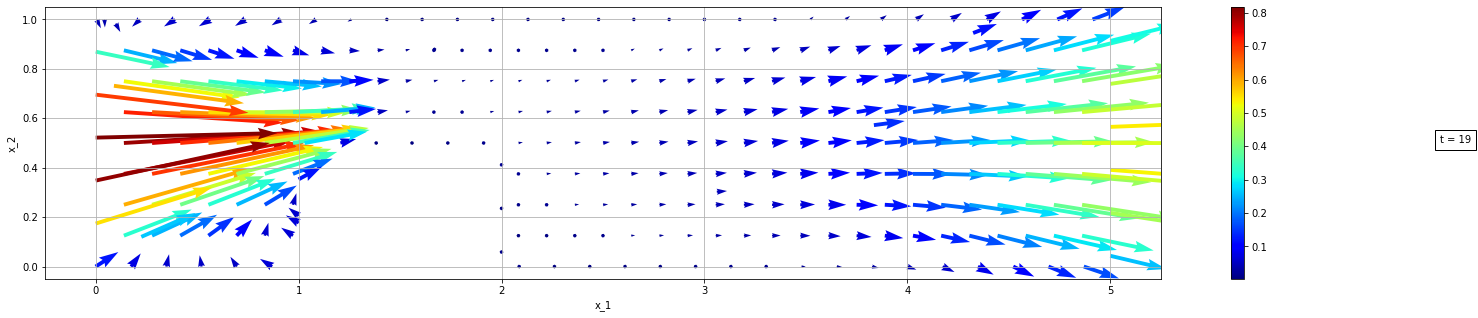

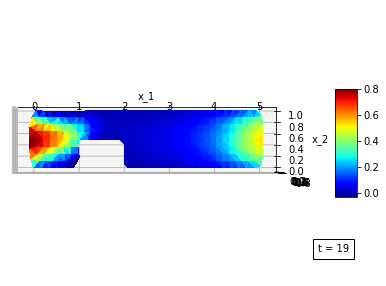

In [10]:
from torchphysics.utils.plot import _plot
tplot = 19
fig1 = _plot(model=solver.model, plot_variables=x, 
            points=300, angle=[30, 220], 
            dic_for_other_variables={'t' : tplot})

fig1 = _plot(model=solver.model, plot_variables=x, plot_output_entries=[0], 
            points=300, angle=[90, 270], 
            dic_for_other_variables={'t' : tplot})
fig1.axes[0].set_box_aspect(aspect = (4,1,1))
fig1.set_size_inches(10,5)

MovieWriter ffmpeg unavailable; using Pillow instead.


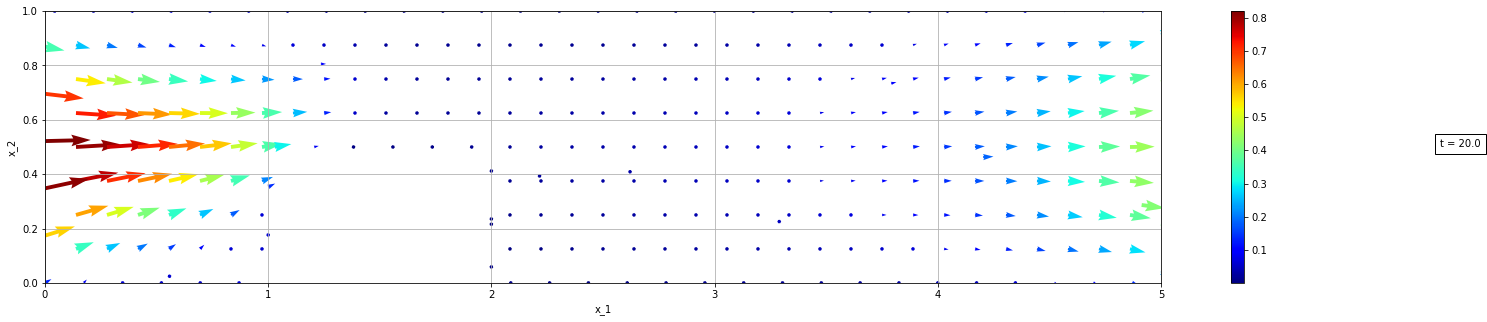

In [11]:
%load_ext autoreload
%autoreload 2
from torchphysics.utils.animation import animation
fig, ani = animation(model=solver.model, plot_variables=x, domain_points=300, 
                animation_variable=t, frame_number=100)
ani.save('flow.gif')